https://www.sciencedirect.com/science/article/pii/S1568494620306803?casa_token=4ieLFywpVeUAAAAA:PeXRbdBj46bl9y-0SZOOE30EekImtXEMDC592HLOaOSNjKVMLBh5a9-MKeVbrATUJE8RwrSl#b26

# Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Notebooks"

/content/drive/.shortcut-targets-by-id/1-0yfWCW69kavV8g4Zyl8jxmL2psN6QQU/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Notebooks


In [3]:
!pip install import-ipynb
import import_ipynb

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from torch.optim import Optimizer
from torch.distributions import Bernoulli, Normal
import torchvision.models

from copy import deepcopy

In [5]:
import Optimizers

importing Jupyter notebook from Optimizers.ipynb


In [6]:
# import misc

# Get Data Loader

In [7]:
def get_data_loader(target_classes, batch_size, num_workers):
    np.random.seed(1000) # fixed numpy seed for reproducible shuffling
    classes = ['Covid Negative', 'Covid Positive'] # classes are folders in each directory with these names

    tensor_data_path = "/content/drive/My Drive/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Data/Tensor/"
    data = torchvision.datasets.DatasetFolder(tensor_data_path, loader=torch.load, extensions=('.pt')) # stored in tensors
    
    relevant_indices = list(range(len(data)))
    np.random.shuffle(relevant_indices)
    # relevant_indices = relevant_indices[0:1000]

    # Splitting data: 70% train, 15% validation, 15% test
    train_val_split = int(len(relevant_indices) * 0.7)
    val_test_split = int(len(relevant_indices) * 0.85)
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:train_val_split], relevant_indices[train_val_split:val_test_split], relevant_indices[val_test_split:]

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler, drop_last=True)
    
    val_sampler = SubsetRandomSampler(relevant_val_indices) 
    val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler, drop_last=True)

    test_sampler = SubsetRandomSampler(relevant_test_indices) 
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler, drop_last=True)

    return train_loader, val_loader, test_loader, classes

# Training Code

In [8]:
# Generate a name for each training hyperparameter settings, which is a string consisting of all hyperparameters of a model
def get_model_name(name, batch_size, other_param_names, epoch):
    path = "model_{0}_bs{1}_{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   other_param_names,
                                                   epoch)
    return path  #get a string consisting of all hyperparameters of a model

In [9]:
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

In [10]:
def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)

        loss = criterion(outputs+1e-10, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels.tolist())

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [11]:
def train(model, train_data, val_data, optimizer, other_param_names, batch_size=64, num_epochs=1):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    train_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    
    
    # training
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        
        for i, data in enumerate(train_data):
            inputs, labels = data # Get the inputs
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()

            out = model(inputs)             # forward pass
            loss = criterion(out+1e-10, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Save the current training information
            total_train_loss += loss.item()             # compute train loss
        
        # Calculate error and loss for training and validation set for this epoch
        train_err[epoch], train_loss[epoch] = evaluate(model, train_data, criterion)   # compute average train error and loss
        val_err[epoch], val_loss[epoch] = evaluate(model, val_data, criterion)   # compute validation error and loss
        print(("Epoch {}: Train err: {}, Train loss: {} | "+
               "Val err: {}, Val loss: {} | Time: {:.2f}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch], 
                   time.time() - start_time))
        
        # Save the current model (checkpoint) to a file, every 10 epoch - always save the last epoch
        if (epoch % 10 == 0) or (epoch == num_epochs-1):
          model_path = get_model_name(model.name, batch_size, other_param_names, epoch)
          torch.save(model.state_dict(), model_path)
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # Write the train/test loss/accuracy into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    model_path = get_model_name(model.name, batch_size, other_param_names, num_epochs)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Final Training Error: {}".format(train_err[-1]))

In [12]:
def plot_training_curve(path, epochs=1):
    # Load the training and validation accuracy and loss
    train_acc = np.loadtxt("{}_train_err.csv".format(path))
    val_acc = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    
    plt.title("Train vs Validation Classification Error")
    plt.plot(range(1,epochs+1), train_acc, label="Train")
    plt.plot(range(1,epochs+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Classification Error")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,epochs+1), train_loss, label="Train")
    plt.plot(range(1,epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    
    plt.show()

# misc for Optimizers

https://github.com/nicklashansen/neural-net-optimization/blob/master/misc.py

In [13]:
optim_dict = {
		'sgd': {
			'label': 'SGD',
			'lr': 1e-3
		},
		'sgd_momentum': {
			'label': 'SGD w/ momentum',
			'lr': 1e-3,
			'mu': 0.99
		},
		'sgd_nesterov': {
			'label': 'SGD w/ Nesterov momentum',
			'lr': 1e-3,
			'mu': 0.99,
			'nesterov': True
		},
		'sgd_weight_decay': {
			'label': 'SGDW',
			'lr': 1e-3,
			'mu': 0.99,
			'weight_decay': 1e-6
		},
		'sgd_lrd': {
			'label': 'SGD w/ momentum + LRD',
			'lr': 1e-3,
			'mu': 0.99,
			'lrd': 0.5
		},
		'adam': {
			'label': 'Adam',
			'lr': 1e-3
		},
		'adamW':{
			'label': 'AdamW',
			'lr': 1e-3,
			'weight_decay': 1e-4
		},
		'adam_l2':{
			'label': 'AdamL2',
			'lr': 1e-3,
			'l2_reg': 1e-4
		},
		'adam_lrd': {
			'label': 'Adam w/ LRD',
			'lr': 1e-3,
			'lrd': 0.5
		},
		'Radam': {
			'label': 'RAdam',
			'lr': 1e-3,
			'rectified': True
		},
		'RadamW': {
			'label': 'RAdamW',
			'lr': 1e-3,
			'rectified': True,
			'weight_decay': 1e-4
		},
		'Radam_lrd': {
			'label': 'RAdam w/ LRD',
			'lr': 1e-3,
			'rectified': True,
			'lrd': 0.5
		},
		'nadam': {
			'label': 'Nadam',
			'lr': 1e-3,
			'nesterov': True
		},
		'rmsprop': {
			'label': 'RMSprop',
			'lr': 1e-3,
			'beta2': 0.9,
		},
		'lookahead_sgd': {
			'label': 'Lookahead (SGD)',
			'lr': 1e-3,
			'mu': 0.99
		},
		'lookahead_adam': {
			'label': 'Lookahead (Adam)',
			'lr': 1e-3
		},
		'gradnoise_adam': {
			'label': 'Gradient Noise (Adam)',
			'lr': 1e-3
		},
		'graddropout_adam': {
			'label': 'Gradient Dropout (Adam)',
			'lr': 1e-3
		}
	}

In [14]:
def split_optim_dict(d:dict) -> tuple:
	"""
	Splits an optimization dict into label and dict.
	"""
	temp_d = deepcopy(d)
	label = temp_d['label']
	del temp_d['label']

	return label, temp_d

In [15]:
def task_to_optimizer(task:str) -> torch.optim.Optimizer:
	"""
	Takes a task as string and returns its respective optimizer class.
	"""
	optimizer = None

	if 'sgd' in task.lower():
		optimizer = getattr(Optimizers, 'SGD')
	if 'adam' in task.lower():
		optimizer = getattr(Optimizers, 'Adam')
	if 'rmsprop' in task.lower():
		optimizer = getattr(Optimizers, 'RMSProp')
	
	if optimizer is None:
		raise ValueError(f'Optimizer for task \'{task}\' was not recognized!')

	return optimizer

In [16]:
def wrap_optimizer(task:str, optimizer):
	"""
	Wraps an instantiated optimizer according to its task specified as a string.
	"""
	if 'gradnoise' in task.lower():
		optimizer = Optimizers.GradientNoise(optimizer, eta=0.3, gamma=0.55)

	if 'graddropout' in task.lower():
		optimizer = Optimizers.GradientDropout(optimizer, grad_retain=0.9)

	if 'lookahead' in task.lower():
		optimizer = Optimizers.Lookahead(optimizer, k=5, alpha=0.5)

	return optimizer

# Model Training

In [17]:
# get number of images in training, validation, and testing sets
# print('Num in training set:',len(train_loader)*batch_size)
# print('Num in validation set:',len(val_loader)*batch_size)
# print('Num in testing set:',len(test_loader)*batch_size)

In [18]:
# Visualize some sample data
# dataiter = iter(train_loader)
# images,labels = dataiter.next()
# images = images.numpy()
# classes = ['Covid Negative', 'Covid Positive']
# # plot the images in the batch, along with corresponding labels
# fig = plt.figure(figsize=(25,4))
# for idx in np.arange(20):
#   ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#   plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#   ax.set_title(classes[labels[idx]])

In [19]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
#model.eval()

# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 340)
# model.features.conv0.apply(squeeze_weights)
# model.classifier2 = nn.Linear(340, 1)

In [20]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# model.classifier.in_features

In [21]:
opt_tasks = [
		'sgd',
		'sgd_momentum',
		'sgd_nesterov',
		'sgd_weight_decay',
		'sgd_lrd',
		'rmsprop',
		'adam',
		'adam_l2',
		'adamW',
		'adam_lrd',
		'Radam',
		'RadamW',
		'Radam_lrd',
		'nadam',
		'lookahead_sgd',
		'lookahead_adam',
		'gradnoise_adam',
		'graddropout_adam'
	]

https://www.kaggle.com/code/leighplt/densenet121-pytorch/notebook

In [22]:
class TransferDenseNet121Classifier_Adam(nn.Module):
    def __init__(self):
        super(TransferDenseNet121Classifier_Adam, self).__init__()
        self.name = 'densenet121Classifier_adam'
        preloaded = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        self.features = preloaded.features

        self.features.conv0 = nn.Conv2d(3, 64, 7, 2, 3) # in_channels, out_channels, kernel_size, stride, padding
        # self.num_ftrs = self.model.classifier.in_features
        self.fc1 = nn.Linear(1024, 340)
        self.fc2 = nn.Linear(340, 1)
        del preloaded
    
    def forward(self, x):
        features = self.features(x)
        x = F.relu(features, inplace=True)
        # x = x.view(-1, self.num_ftrs)
        # x = F.relu(features, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(features.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [23]:
class TransferDenseNet121Classifier_AdamLRD(nn.Module):
    def __init__(self):
        super(TransferDenseNet121Classifier_AdamLRD, self).__init__()
        self.name = 'densenet121Classifier_adamLRD'
        preloaded = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        self.features = preloaded.features

        self.features.conv0 = nn.Conv2d(3, 64, 7, 2, 3)
        # self.num_ftrs = self.model.classifier.in_features
        self.fc1 = nn.Linear(1024, 340)
        self.fc2 = nn.Linear(340, 1)
        del preloaded
    
    def forward(self, x):
        features = self.features(x)
        x = F.relu(features, inplace=True)
        # x = x.view(-1, self.num_ftrs)
        # x = F.relu(features, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(features.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

* SGD (Amanda), SGD w/ momentum (Coco), SGD w/ Nesterov momentum (Amanda), SGD w/ LRD (Coco)
* Adam (Nancy), Adam w/ L2 (Kelly), Adam w/ LRD (Nancy), AdamW (Kelly)
* KO optimizer

hyperparameter combinations:
1. bs=32, lr=0.01, num_epochs=30
2. bs=32, lr=0.001, num_epochs=30
3. bs=64, lr=0.01, num_epochs=30
4. bs=64, lr=0.001, num_epochs=30
5. bs=128, lr=0.01, num_epochs=30
6. bs=128, lr=0.001, num_epochs=30

### Adam

batch size = 32, learning rate = 0.01


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

{'lr': 0.01}
Training with CUDA!
Epoch 1: Train err: 0.4409722222222222, Train loss: 0.6899877058135139 | Val err: 0.4652777777777778, Val loss: 0.6946827835506864 | Time: 355.83
Epoch 2: Train err: 0.35694444444444445, Train loss: 0.6402660568555196 | Val err: 0.3819444444444444, Val loss: 0.6799166136317782 | Time: 406.14
Epoch 3: Train err: 0.25555555555555554, Train loss: 0.5246118095186022 | Val err: 0.2361111111111111, Val loss: 0.5227165751987033 | Time: 452.67
Epoch 4: Train err: 0.24930555555555556, Train loss: 0.5112275898456573 | Val err: 0.2604166666666667, Val loss: 0.5222742160161337 | Time: 499.38
Epoch 5: Train err: 0.21875, Train loss: 0.4686778446038564 | Val err: 0.20833333333333334, Val loss: 0.49040450652440387 | Time: 546.00
Epoch 6: Train err: 0.21180555555555555, Train loss: 0.4263617538743549 | Val err: 0.2222222222222222, Val loss: 0.44781820310486686 | Time: 592.62
Epoch 7: Train err: 0.23194444444444445, Train loss: 0.4292332887649536 | Val err: 0.21875, Val

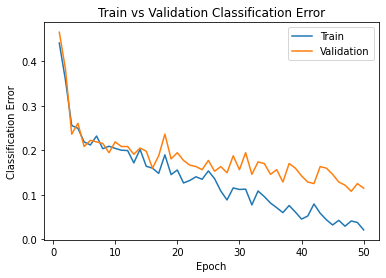

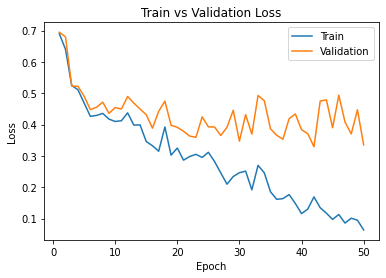

batch size = 32, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001}
Training with CUDA!
Epoch 1: Train err: 0.1951388888888889, Train loss: 0.4158749282360077 | Val err: 0.19444444444444445, Val loss: 0.4579308099216885 | Time: 47.19
Epoch 2: Train err: 0.17847222222222223, Train loss: 0.37033122612370384 | Val err: 0.19791666666666666, Val loss: 0.4029519359270732 | Time: 94.21
Epoch 3: Train err: 0.16180555555555556, Train loss: 0.3401307761669159 | Val err: 0.19444444444444445, Val loss: 0.41680989000532365 | Time: 140.89
Epoch 4: Train err: 0.15416666666666667, Train loss: 0.31401828726132713 | Val err: 0.20833333333333334, Val loss: 0.397381196419398 | Time: 187.39
Epoch 5: Train err: 0.15833333333333333, Train loss: 0.31782461934619477 | Val err: 0.20833333333333334, Val loss: 0.40381870336002773 | Time: 234.00
Epoch 6: Train err: 0.12013888888888889, Train loss: 0.25640209780799017 | Val err: 0.1388888888888889, Val loss: 0.3464799125989278 | Time: 280.80
Epoch 7: Train err: 0.10277777777777777, Train loss: 0.21989413797855378 | Va

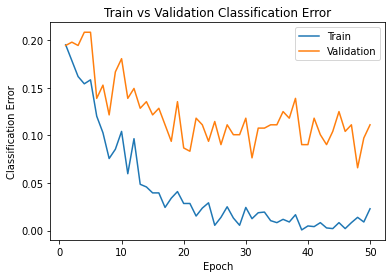

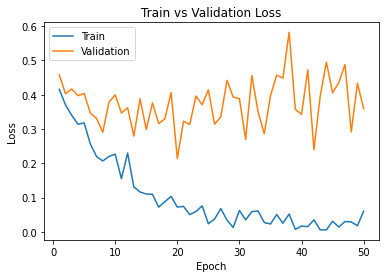

batch size = 64, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01}
Training with CUDA!
Epoch 1: Train err: 0.5078125, Train loss: 0.6927229301495985 | Val err: 0.51171875, Val loss: 0.6927086263895035 | Time: 36.92
Epoch 2: Train err: 0.2897727272727273, Train loss: 0.6347742758013986 | Val err: 0.3046875, Val loss: 0.6379324942827225 | Time: 73.17
Epoch 3: Train err: 0.296875, Train loss: 0.6308596432209015 | Val err: 0.28125, Val loss: 0.6630948930978775 | Time: 109.13
Epoch 4: Train err: 0.234375, Train loss: 0.4927735301581296 | Val err: 0.2265625, Val loss: 0.5019600987434387 | Time: 145.10
Epoch 5: Train err: 0.20880681818181818, Train loss: 0.4773854667490179 | Val err: 0.234375, Val loss: 0.49068300426006317 | Time: 181.11
Epoch 6: Train err: 0.2080965909090909, Train loss: 0.44656494801694696 | Val err: 0.1796875, Val loss: 0.4129485785961151 | Time: 217.10
Epoch 7: Train err: 0.19744318181818182, Train loss: 0.4133665751327168 | Val err: 0.1953125, Val loss: 0.41938843578100204 | Time: 253.00
Epoch 8: Train err: 0.20028409090909

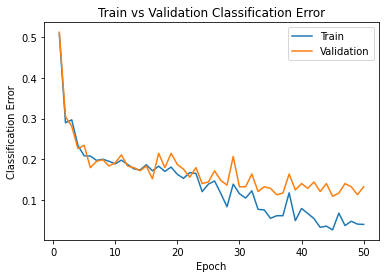

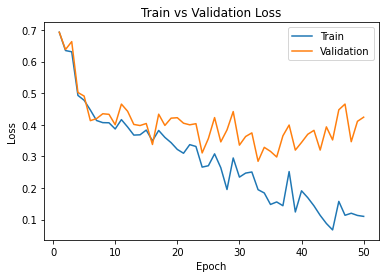

batch size = 64, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001}
Training with CUDA!
Epoch 1: Train err: 0.14701704545454544, Train loss: 0.3106989488005638 | Val err: 0.16015625, Val loss: 0.3457132577896118 | Time: 37.32
Epoch 2: Train err: 0.08735795454545454, Train loss: 0.230457181957635 | Val err: 0.12109375, Val loss: 0.2969202846288681 | Time: 73.94
Epoch 3: Train err: 0.12002840909090909, Train loss: 0.2816589925099503 | Val err: 0.109375, Val loss: 0.3071134202182293 | Time: 110.22
Epoch 4: Train err: 0.07315340909090909, Train loss: 0.1806048879569227 | Val err: 0.1171875, Val loss: 0.28060072660446167 | Time: 146.39
Epoch 5: Train err: 0.09730113636363637, Train loss: 0.22973006184805522 | Val err: 0.11328125, Val loss: 0.30986853688955307 | Time: 182.63
Epoch 6: Train err: 0.06960227272727272, Train loss: 0.16458712044087323 | Val err: 0.1328125, Val loss: 0.30882781744003296 | Time: 218.99
Epoch 7: Train err: 0.05184659090909091, Train loss: 0.13244433362375607 | Val err: 0.12109375, Val loss: 0.2729612812399864 | Time: 2

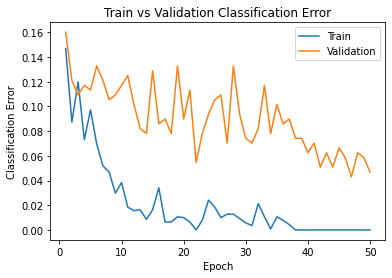

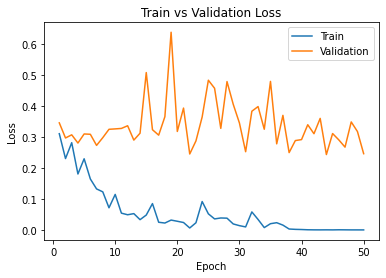

In [ ]:
bs_list = [32, 64]
lr_list = [0.01, 0.001]
for bs in bs_list:
  for lr in lr_list:
    # Train with batch size and learning rate
    print('batch size = {}, learning rate = {}'.format(bs, lr))
    train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
    use_cuda = True
    model = TransferDenseNet121Classifier_Adam()
    _, kwargs = split_optim_dict(optim_dict['adam'])
    kwargs['lr'] = lr
    print(kwargs)
    optimizer = task_to_optimizer('adam')(params=model.parameters(), **kwargs)
    optimizer = wrap_optimizer('adam', optimizer)
    if use_cuda and torch.cuda.is_available():
      model.cuda()
      print("Training with CUDA!")
    else:
      print("CUDA not available...")
    other_param_names = 'lr{}'.format(lr)
    train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=bs, num_epochs=50)

    # Plotting
    model_path = get_model_name('densenet121Classifier_adam', bs, other_param_names, epoch=50)
    plot_training_curve(model_path, epochs=50)

### Adam w/ LRD

batch size = 32, learning rate = 0.01


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

{'lr': 0.01, 'lrd': 0.3}
Training with CUDA!
Epoch 1: Train err: 0.2513888888888889, Train loss: 0.4763905154334174 | Val err: 0.2326388888888889, Val loss: 0.47429751687579685 | Time: 146.56
Epoch 2: Train err: 0.18263888888888888, Train loss: 0.4196780959765116 | Val err: 0.19444444444444445, Val loss: 0.43852457735273576 | Time: 172.00
Epoch 3: Train err: 0.19722222222222222, Train loss: 0.40769360529051885 | Val err: 0.20833333333333334, Val loss: 0.455341163608763 | Time: 194.70
Epoch 4: Train err: 0.27569444444444446, Train loss: 0.5382740292284224 | Val err: 0.2638888888888889, Val loss: 0.5380801293585036 | Time: 217.48
Epoch 5: Train err: 0.18819444444444444, Train loss: 0.40890315704875524 | Val err: 0.19791666666666666, Val loss: 0.4294101728333367 | Time: 240.33
Epoch 6: Train err: 0.1638888888888889, Train loss: 0.3620642619000541 | Val err: 0.2222222222222222, Val loss: 0.4281790488296085 | Time: 263.04
Epoch 7: Train err: 0.1638888888888889, Train loss: 0.361081095205413

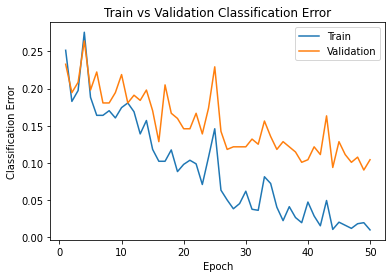

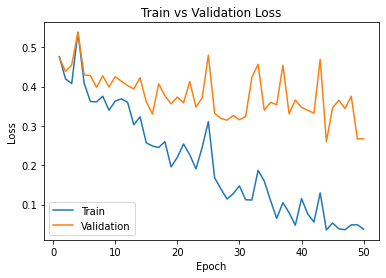

batch size = 32, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.2222222222222222, Train loss: 0.44419957995414733 | Val err: 0.2222222222222222, Val loss: 0.44498051206270856 | Time: 24.15
Epoch 2: Train err: 0.21180555555555555, Train loss: 0.44588437875111897 | Val err: 0.20833333333333334, Val loss: 0.47168362471792435 | Time: 47.53
Epoch 3: Train err: 0.20347222222222222, Train loss: 0.42509855892923143 | Val err: 0.17708333333333334, Val loss: 0.4450289871957567 | Time: 70.70
Epoch 4: Train err: 0.21944444444444444, Train loss: 0.46197557581795584 | Val err: 0.2222222222222222, Val loss: 0.46355020337634617 | Time: 93.85
Epoch 5: Train err: 0.19375, Train loss: 0.41653853588634066 | Val err: 0.2013888888888889, Val loss: 0.41529664397239685 | Time: 116.92
Epoch 6: Train err: 0.18263888888888888, Train loss: 0.38474908272425334 | Val err: 0.19791666666666666, Val loss: 0.41316868199242485 | Time: 139.89
Epoch 7: Train err: 0.17291666666666666, Train loss: 0.38360427849822576 | V

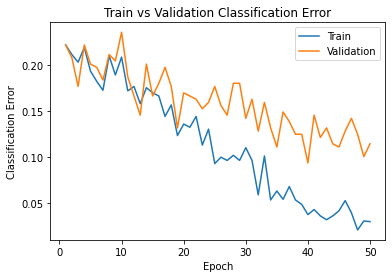

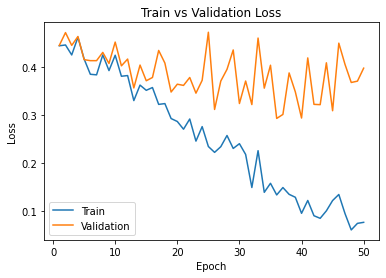

batch size = 32, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.2604166666666667, Train loss: 0.4984599577056037 | Val err: 0.25, Val loss: 0.5206068886650933 | Time: 24.14
Epoch 2: Train err: 0.21805555555555556, Train loss: 0.45297660960091485 | Val err: 0.21180555555555555, Val loss: 0.48927493890126544 | Time: 47.94
Epoch 3: Train err: 0.20208333333333334, Train loss: 0.40544168286853366 | Val err: 0.2222222222222222, Val loss: 0.4671318365467919 | Time: 71.70
Epoch 4: Train err: 0.2722222222222222, Train loss: 0.48646442426575554 | Val err: 0.3055555555555556, Val loss: 0.5644506514072418 | Time: 95.53
Epoch 5: Train err: 0.2125, Train loss: 0.4189159678088294 | Val err: 0.21180555555555555, Val loss: 0.44049230217933655 | Time: 118.66
Epoch 6: Train err: 0.22083333333333333, Train loss: 0.4189130663871765 | Val err: 0.22916666666666666, Val loss: 0.46884848011864555 | Time: 142.19
Epoch 7: Train err: 0.20347222222222222, Train loss: 0.3995077391465505 | Val err: 0.211805555555

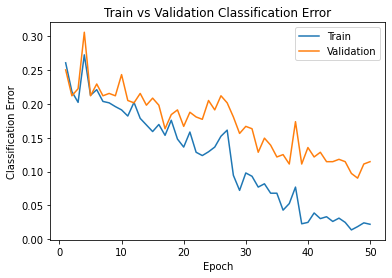

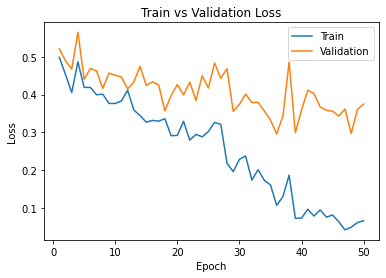

batch size = 32, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.24097222222222223, Train loss: 0.5053058339489831 | Val err: 0.2361111111111111, Val loss: 0.5295960240893893 | Time: 23.77
Epoch 2: Train err: 0.21736111111111112, Train loss: 0.4441419117980533 | Val err: 0.24305555555555555, Val loss: 0.49482173058721757 | Time: 47.21
Epoch 3: Train err: 0.23194444444444445, Train loss: 0.4800327883826362 | Val err: 0.25, Val loss: 0.4947434498204125 | Time: 70.37
Epoch 4: Train err: 0.25, Train loss: 0.48289143509334986 | Val err: 0.2708333333333333, Val loss: 0.513774659898546 | Time: 93.58
Epoch 5: Train err: 0.2013888888888889, Train loss: 0.4333868722120921 | Val err: 0.2048611111111111, Val loss: 0.45222532749176025 | Time: 116.64
Epoch 6: Train err: 0.21805555555555556, Train loss: 0.45750472876760695 | Val err: 0.2222222222222222, Val loss: 0.45976770255300736 | Time: 139.74
Epoch 7: Train err: 0.2048611111111111, Train loss: 0.4176748633384705 | Val err: 0.21180555555555555,

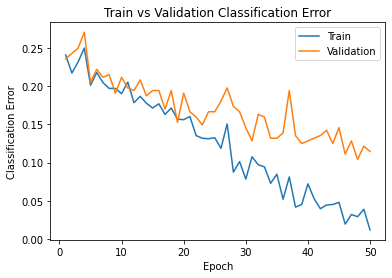

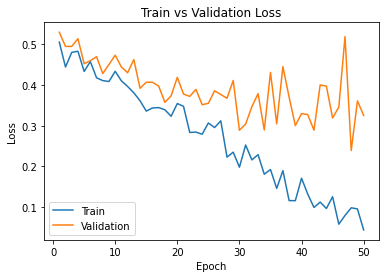

batch size = 32, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.3}
Training with CUDA!
Epoch 1: Train err: 0.11041666666666666, Train loss: 0.2683284130361345 | Val err: 0.16666666666666666, Val loss: 0.35285123851564193 | Time: 23.96
Epoch 2: Train err: 0.06527777777777778, Train loss: 0.1508072276910146 | Val err: 0.12152777777777778, Val loss: 0.3043042752477858 | Time: 47.56
Epoch 3: Train err: 0.05138888888888889, Train loss: 0.13784472321470578 | Val err: 0.11805555555555555, Val loss: 0.276762992143631 | Time: 70.88
Epoch 4: Train err: 0.05555555555555555, Train loss: 0.14975019577476714 | Val err: 0.11458333333333333, Val loss: 0.33456438614262474 | Time: 94.08
Epoch 5: Train err: 0.025694444444444443, Train loss: 0.06639139627416929 | Val err: 0.09375, Val loss: 0.23615706463654837 | Time: 117.32
Epoch 6: Train err: 0.015277777777777777, Train loss: 0.039337056833836766 | Val err: 0.059027777777777776, Val loss: 0.21824183563391367 | Time: 140.61
Epoch 7: Train err: 0.021527777777777778, Train loss: 0.059977211058139

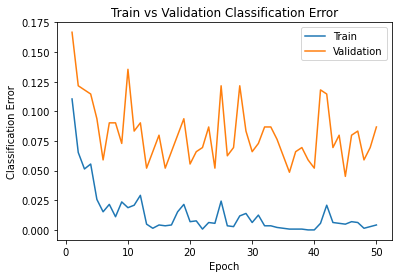

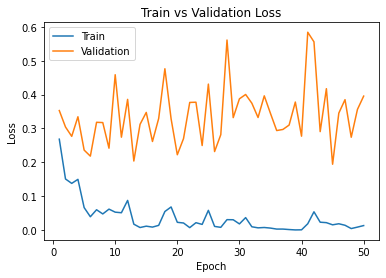

batch size = 32, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.11458333333333333, Train loss: 0.2696933517853419 | Val err: 0.1527777777777778, Val loss: 0.32874134845203823 | Time: 23.90
Epoch 2: Train err: 0.07083333333333333, Train loss: 0.21058741841051315 | Val err: 0.11805555555555555, Val loss: 0.2850250005722046 | Time: 47.33
Epoch 3: Train err: 0.08680555555555555, Train loss: 0.22354534450504515 | Val err: 0.1701388888888889, Val loss: 0.39736198385556537 | Time: 70.56
Epoch 4: Train err: 0.049305555555555554, Train loss: 0.1332790531631973 | Val err: 0.09722222222222222, Val loss: 0.28354665637016296 | Time: 93.75
Epoch 5: Train err: 0.041666666666666664, Train loss: 0.10720225489801831 | Val err: 0.10416666666666667, Val loss: 0.2570568496982257 | Time: 116.98
Epoch 6: Train err: 0.05277777777777778, Train loss: 0.15393197362621625 | Val err: 0.1388888888888889, Val loss: 0.31819921566380394 | Time: 140.13
Epoch 7: Train err: 0.049305555555555554, Train loss: 0.1306519

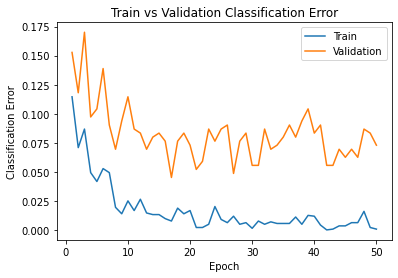

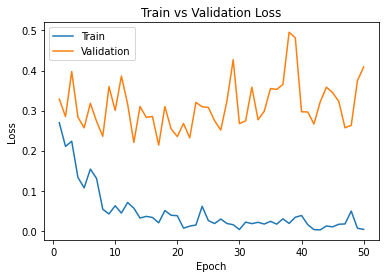

batch size = 32, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.12361111111111112, Train loss: 0.28009606533580356 | Val err: 0.1527777777777778, Val loss: 0.36464565992355347 | Time: 23.61
Epoch 2: Train err: 0.09236111111111112, Train loss: 0.2240246464808782 | Val err: 0.13194444444444445, Val loss: 0.34729604257477653 | Time: 47.10
Epoch 3: Train err: 0.07777777777777778, Train loss: 0.20824507888820437 | Val err: 0.1527777777777778, Val loss: 0.3918464399046368 | Time: 70.43
Epoch 4: Train err: 0.09652777777777778, Train loss: 0.22465521941582361 | Val err: 0.12152777777777778, Val loss: 0.29793572260273826 | Time: 93.73
Epoch 5: Train err: 0.04513888888888889, Train loss: 0.11695704439447986 | Val err: 0.09375, Val loss: 0.2848286194105943 | Time: 117.00
Epoch 6: Train err: 0.04652777777777778, Train loss: 0.1296059449513753 | Val err: 0.10069444444444445, Val loss: 0.2649873329533471 | Time: 140.36
Epoch 7: Train err: 0.01597222222222222, Train loss: 0.05307471077475283 | Va

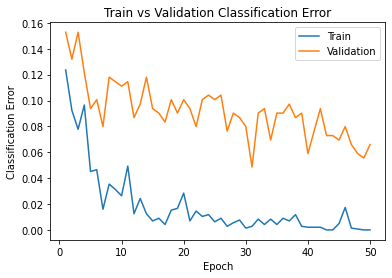

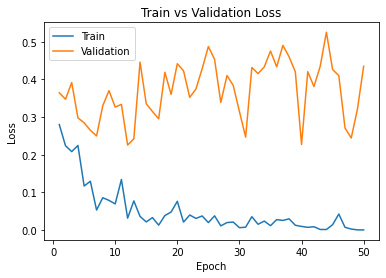

batch size = 32, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.1486111111111111, Train loss: 0.3214518772231208 | Val err: 0.1736111111111111, Val loss: 0.37450916237301296 | Time: 23.89
Epoch 2: Train err: 0.10416666666666667, Train loss: 0.2521447925104035 | Val err: 0.14930555555555555, Val loss: 0.3432740006181929 | Time: 47.60
Epoch 3: Train err: 0.11805555555555555, Train loss: 0.29580325484275816 | Val err: 0.1527777777777778, Val loss: 0.396463758415646 | Time: 70.87
Epoch 4: Train err: 0.09930555555555555, Train loss: 0.2573465585708618 | Val err: 0.13541666666666666, Val loss: 0.32901791565948063 | Time: 94.11
Epoch 5: Train err: 0.05138888888888889, Train loss: 0.1254411573211352 | Val err: 0.1284722222222222, Val loss: 0.30454796966579223 | Time: 117.44
Epoch 6: Train err: 0.049305555555555554, Train loss: 0.1309443069001039 | Val err: 0.09375, Val loss: 0.27707653989394504 | Time: 140.71
Epoch 7: Train err: 0.07013888888888889, Train loss: 0.1617100170916981 | Val err

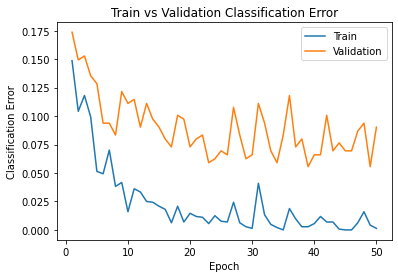

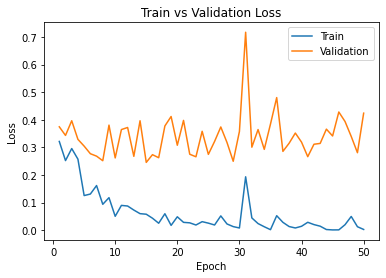

batch size = 64, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'lrd': 0.3}
Training with CUDA!
Epoch 1: Train err: 0.21803977272727273, Train loss: 0.4562778662551533 | Val err: 0.234375, Val loss: 0.47320380061864853 | Time: 20.18
Epoch 2: Train err: 0.2059659090909091, Train loss: 0.41682997752319684 | Val err: 0.24609375, Val loss: 0.4987335875630379 | Time: 39.96
Epoch 3: Train err: 0.21661931818181818, Train loss: 0.4324525242502039 | Val err: 0.22265625, Val loss: 0.43464313447475433 | Time: 59.49
Epoch 4: Train err: 0.17045454545454544, Train loss: 0.3612029566006227 | Val err: 0.17578125, Val loss: 0.3896751329302788 | Time: 79.05
Epoch 5: Train err: 0.1825284090909091, Train loss: 0.3577655086463148 | Val err: 0.22265625, Val loss: 0.42403800040483475 | Time: 98.61
Epoch 6: Train err: 0.18323863636363635, Train loss: 0.3593312921849164 | Val err: 0.171875, Val loss: 0.3749154508113861 | Time: 118.22
Epoch 7: Train err: 0.15696022727272727, Train loss: 0.3360376317392696 | Val err: 0.18359375, Val loss: 0.41632258892059326 | T

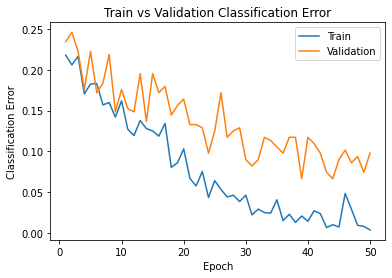

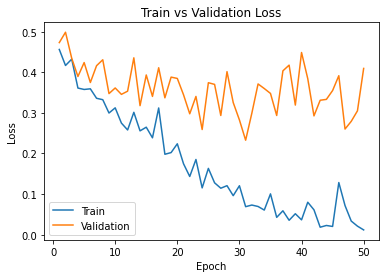

batch size = 64, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.25, Train loss: 0.5232148441401395 | Val err: 0.25390625, Val loss: 0.5238839536905289 | Time: 20.17
Epoch 2: Train err: 0.1953125, Train loss: 0.4185349954800172 | Val err: 0.2265625, Val loss: 0.4768277779221535 | Time: 39.98
Epoch 3: Train err: 0.20241477272727273, Train loss: 0.4470558613538742 | Val err: 0.234375, Val loss: 0.4637290760874748 | Time: 59.49
Epoch 4: Train err: 0.18963068181818182, Train loss: 0.3799744654785503 | Val err: 0.2109375, Val loss: 0.43212178349494934 | Time: 78.99
Epoch 5: Train err: 0.21732954545454544, Train loss: 0.4330794404853474 | Val err: 0.22265625, Val loss: 0.5135634243488312 | Time: 98.51
Epoch 6: Train err: 0.1903409090909091, Train loss: 0.38724108175797894 | Val err: 0.1953125, Val loss: 0.42429498583078384 | Time: 117.95
Epoch 7: Train err: 0.19105113636363635, Train loss: 0.381336972117424 | Val err: 0.19140625, Val loss: 0.4501649886369705 | Time: 137.38
Epoch 8: Train e

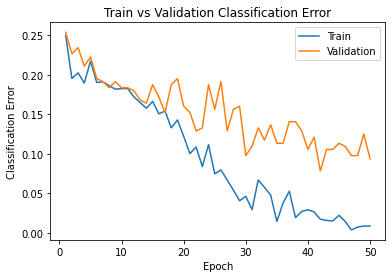

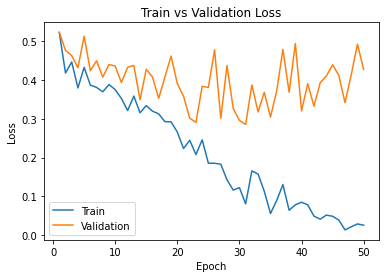

batch size = 64, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.28480113636363635, Train loss: 0.5597599907354875 | Val err: 0.3125, Val loss: 0.5670433193445206 | Time: 20.11
Epoch 2: Train err: 0.21732954545454544, Train loss: 0.4497340240261771 | Val err: 0.21484375, Val loss: 0.47594040632247925 | Time: 39.72
Epoch 3: Train err: 0.21235795454545456, Train loss: 0.4556097130883824 | Val err: 0.2109375, Val loss: 0.4623415246605873 | Time: 59.17
Epoch 4: Train err: 0.203125, Train loss: 0.4224124699831009 | Val err: 0.203125, Val loss: 0.4688844010233879 | Time: 78.58
Epoch 5: Train err: 0.21306818181818182, Train loss: 0.4456217736005783 | Val err: 0.2265625, Val loss: 0.46692706644535065 | Time: 97.98
Epoch 6: Train err: 0.19389204545454544, Train loss: 0.39416485076600855 | Val err: 0.19140625, Val loss: 0.4378737211227417 | Time: 117.43
Epoch 7: Train err: 0.19744318181818182, Train loss: 0.3860353353348645 | Val err: 0.21484375, Val loss: 0.47899600863456726 | Time: 136.85
Ep

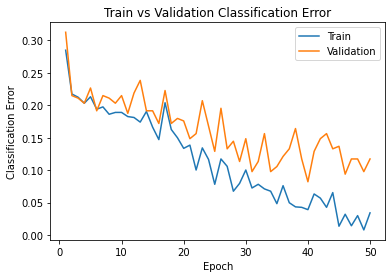

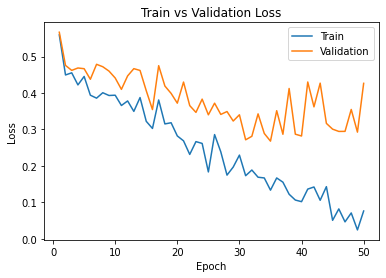

batch size = 64, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.01, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.2507102272727273, Train loss: 0.49196096577427606 | Val err: 0.2578125, Val loss: 0.5244695767760277 | Time: 20.11
Epoch 2: Train err: 0.18963068181818182, Train loss: 0.42118770561435004 | Val err: 0.20703125, Val loss: 0.4486798718571663 | Time: 39.95
Epoch 3: Train err: 0.2109375, Train loss: 0.4198824573646892 | Val err: 0.21484375, Val loss: 0.44266870617866516 | Time: 59.45
Epoch 4: Train err: 0.19957386363636365, Train loss: 0.3960937722162767 | Val err: 0.19921875, Val loss: 0.4325235113501549 | Time: 78.94
Epoch 5: Train err: 0.21448863636363635, Train loss: 0.4443086873401295 | Val err: 0.22265625, Val loss: 0.48085352778434753 | Time: 98.40
Epoch 6: Train err: 0.18678977272727273, Train loss: 0.37480516596273944 | Val err: 0.203125, Val loss: 0.43568408489227295 | Time: 117.86
Epoch 7: Train err: 0.18607954545454544, Train loss: 0.3698087592016567 | Val err: 0.21484375, Val loss: 0.44142089039087296 | Time: 1

In [ ]:
bs_list = [32, 64]
lr_list = [0.01, 0.001]
lrd_list = [0.3, 0.4, 0.5, 0.6]
for bs in bs_list:
  for lr in lr_list:
    for lrd in lrd_list:
      # Train with batch size and learning rate
      print('batch size = {}, learning rate = {}'.format(bs, lr))
      train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
      use_cuda = True
      model = TransferDenseNet121Classifier_AdamLRD()
      _, kwargs = split_optim_dict(optim_dict['adam_lrd'])
      kwargs['lr'], kwargs['lrd'] = lr, lrd
      print(kwargs)
      optimizer = task_to_optimizer('adam_lrd')(params=model.parameters(), **kwargs)
      optimizer = wrap_optimizer('adam_lrd', optimizer)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print("Training with CUDA!")
      else:
        print("CUDA not available...")
      other_param_names = 'lr{}_lrd{}'.format(lr, lrd)
      train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=bs, num_epochs=50)

      # Plotting
      model_path = get_model_name('densenet121Classifier_adamLRD', bs, other_param_names, epoch=50)
      plot_training_curve(model_path, epochs=50)

In [ ]:
bs_list = [64]
lr_list = [0.01]
lrd_list = [0.6]
for bs in bs_list:
  for lr in lr_list:
    for lrd in lrd_list:
      # Train with batch size and learning rate
      print('batch size = {}, learning rate = {}'.format(bs, lr))
      train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
      use_cuda = True
      model = TransferDenseNet121Classifier_AdamLRD()
      _, kwargs = split_optim_dict(optim_dict['adam_lrd'])
      kwargs['lr'], kwargs['lrd'] = lr, lrd
      print(kwargs)
      optimizer = task_to_optimizer('adam_lrd')(params=model.parameters(), **kwargs)
      optimizer = wrap_optimizer('adam_lrd', optimizer)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print("Training with CUDA!")
      else:
        print("CUDA not available...")
      other_param_names = 'lr{}_lrd{}'.format(lr, lrd)
      train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=bs, num_epochs=50)

      # Plotting
      model_path = get_model_name('densenet121Classifier_adamLRD', bs, other_param_names, epoch=50)

batch size = 64, learning rate = 0.01


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

{'lr': 0.01, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.23650568181818182, Train loss: 0.4924981553446163 | Val err: 0.265625, Val loss: 0.5456156060099602 | Time: 213.40
Epoch 2: Train err: 0.20667613636363635, Train loss: 0.4234886399724267 | Val err: 0.22265625, Val loss: 0.48401908576488495 | Time: 263.03
Epoch 3: Train err: 0.2556818181818182, Train loss: 0.5059173432263461 | Val err: 0.25, Val loss: 0.5259466245770454 | Time: 307.41
Epoch 4: Train err: 0.20383522727272727, Train loss: 0.41841291974891315 | Val err: 0.2421875, Val loss: 0.4657401442527771 | Time: 351.80
Epoch 5: Train err: 0.21164772727272727, Train loss: 0.4194262217391621 | Val err: 0.21484375, Val loss: 0.4534072205424309 | Time: 396.18
Epoch 6: Train err: 0.2237215909090909, Train loss: 0.4338189959526062 | Val err: 0.203125, Val loss: 0.4696666970849037 | Time: 440.51
Epoch 7: Train err: 0.1981534090909091, Train loss: 0.3963557170196013 | Val err: 0.21484375, Val loss: 0.4717956632375717 | Time: 4

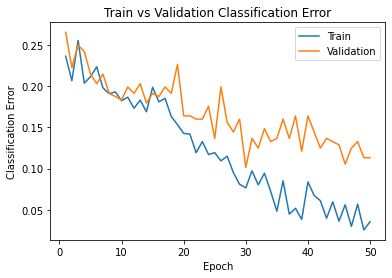

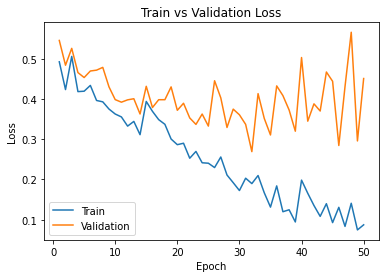

In [ ]:
bs=64
other_param_names = 'lr{}_lrd{}'.format(0.01, 0.6)
model_path = get_model_name('densenet121Classifier_adamLRD', bs, other_param_names, epoch=50)
plot_training_curve(model_path, epochs=50)

batch size = 64, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.3}
Training with CUDA!
Epoch 1: Train err: 0.10724431818181818, Train loss: 0.2598901675506072 | Val err: 0.140625, Val loss: 0.3330850154161453 | Time: 44.83
Epoch 2: Train err: 0.04758522727272727, Train loss: 0.13032287172973156 | Val err: 0.0859375, Val loss: 0.23132703453302383 | Time: 89.81
Epoch 3: Train err: 0.02911931818181818, Train loss: 0.08433405817909674 | Val err: 0.125, Val loss: 0.2791602462530136 | Time: 134.17
Epoch 4: Train err: 0.015625, Train loss: 0.05495990558781407 | Val err: 0.1015625, Val loss: 0.31553004682064056 | Time: 178.58
Epoch 5: Train err: 0.013494318181818182, Train loss: 0.04502098145894706 | Val err: 0.07421875, Val loss: 0.2541020065546036 | Time: 222.98
Epoch 6: Train err: 0.018465909090909092, Train loss: 0.051500200886618004 | Val err: 0.11328125, Val loss: 0.3192700929939747 | Time: 267.47
Epoch 7: Train err: 0.012073863636363636, Train loss: 0.03996078437194228 | Val err: 0.08984375, Val loss: 0.2520298659801483 | Time

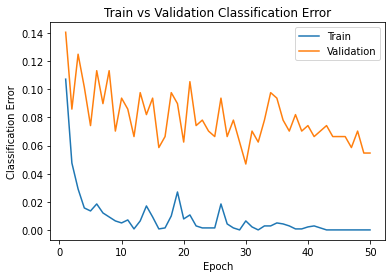

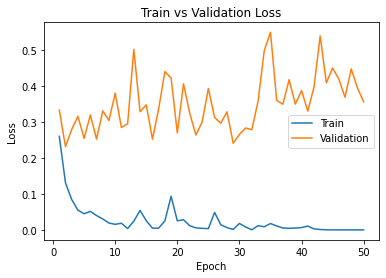

batch size = 64, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.4}
Training with CUDA!
Epoch 1: Train err: 0.08948863636363637, Train loss: 0.2314369807189161 | Val err: 0.1171875, Val loss: 0.3170652985572815 | Time: 45.42
Epoch 2: Train err: 0.06889204545454546, Train loss: 0.161462836983529 | Val err: 0.13671875, Val loss: 0.29373880848288536 | Time: 90.01
Epoch 3: Train err: 0.056107954545454544, Train loss: 0.13128689625723797 | Val err: 0.125, Val loss: 0.3299246095120907 | Time: 134.35
Epoch 4: Train err: 0.029829545454545456, Train loss: 0.09349900636483323 | Val err: 0.1484375, Val loss: 0.3938045799732208 | Time: 178.70
Epoch 5: Train err: 0.018465909090909092, Train loss: 0.05046717610887506 | Val err: 0.0859375, Val loss: 0.22460631281137466 | Time: 223.14
Epoch 6: Train err: 0.01065340909090909, Train loss: 0.032610664440488275 | Val err: 0.078125, Val loss: 0.27288926765322685 | Time: 267.62
Epoch 7: Train err: 0.007102272727272727, Train loss: 0.026988936313004655 | Val err: 0.0625, Val loss: 0.2052828669548034

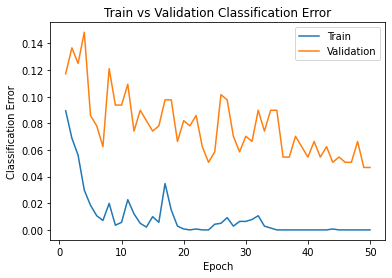

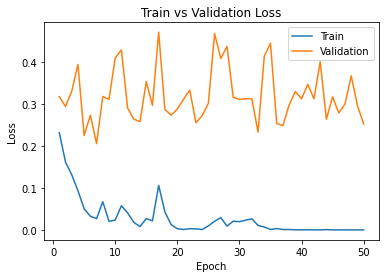

batch size = 64, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.09090909090909091, Train loss: 0.247679280963811 | Val err: 0.1640625, Val loss: 0.36308300495147705 | Time: 45.38
Epoch 2: Train err: 0.07102272727272728, Train loss: 0.19688067585229874 | Val err: 0.11328125, Val loss: 0.2670172490179539 | Time: 90.15
Epoch 3: Train err: 0.0859375, Train loss: 0.22518852556293661 | Val err: 0.12109375, Val loss: 0.37967499345541 | Time: 134.69
Epoch 4: Train err: 0.026278409090909092, Train loss: 0.08298111808570949 | Val err: 0.0859375, Val loss: 0.27960483357310295 | Time: 179.23
Epoch 5: Train err: 0.045454545454545456, Train loss: 0.11745578033680265 | Val err: 0.09375, Val loss: 0.26244430616497993 | Time: 223.80
Epoch 6: Train err: 0.02556818181818182, Train loss: 0.06794354946098545 | Val err: 0.1015625, Val loss: 0.22849762439727783 | Time: 268.36
Epoch 7: Train err: 0.01278409090909091, Train loss: 0.04489272324876352 | Val err: 0.07421875, Val loss: 0.21458005905151367 | Ti

In [ ]:
bs_list = [64]
lr_list = [0.001]
lrd_list = [0.3, 0.4, 0.5, 0.6]
for bs in bs_list:
  for lr in lr_list:
    for lrd in lrd_list:
      # Train with batch size and learning rate
      print('batch size = {}, learning rate = {}'.format(bs, lr))
      train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
      use_cuda = True
      model = TransferDenseNet121Classifier_AdamLRD()
      _, kwargs = split_optim_dict(optim_dict['adam_lrd'])
      kwargs['lr'], kwargs['lrd'] = lr, lrd
      print(kwargs)
      optimizer = task_to_optimizer('adam_lrd')(params=model.parameters(), **kwargs)
      optimizer = wrap_optimizer('adam_lrd', optimizer)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print("Training with CUDA!")
      else:
        print("CUDA not available...")
      other_param_names = 'lr{}_lrd{}'.format(lr, lrd)
      train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=bs, num_epochs=50)

      # Plotting
      model_path = get_model_name('densenet121Classifier_adamLRD', bs, other_param_names, epoch=50)
      plot_training_curve(model_path, epochs=50)

batch size = 64, learning rate = 0.001


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

{'lr': 0.001, 'lrd': 0.5}
Training with CUDA!
Epoch 1: Train err: 0.1545138888888889, Train loss: 0.3400272677342097 | Val err: 0.21875, Val loss: 0.3946799437204997 | Time: 171.97
Epoch 2: Train err: 0.0685763888888889, Train loss: 0.20200520174370873 | Val err: 0.16666666666666666, Val loss: 0.37385905782381695 | Time: 194.36
Epoch 3: Train err: 0.059895833333333336, Train loss: 0.1516895517706871 | Val err: 0.11979166666666667, Val loss: 0.2510647078355153 | Time: 212.83
Epoch 4: Train err: 0.026909722222222224, Train loss: 0.09353152496947183 | Val err: 0.109375, Val loss: 0.32150570054848987 | Time: 229.60
Epoch 5: Train err: 0.018229166666666668, Train loss: 0.06891912842790286 | Val err: 0.10416666666666667, Val loss: 0.2314217040936152 | Time: 246.18
Epoch 6: Train err: 0.027777777777777776, Train loss: 0.06446146758066283 | Val err: 0.13020833333333334, Val loss: 0.30765237907568616 | Time: 262.83
Epoch 7: Train err: 0.013888888888888888, Train loss: 0.03939868013064066 | Val 

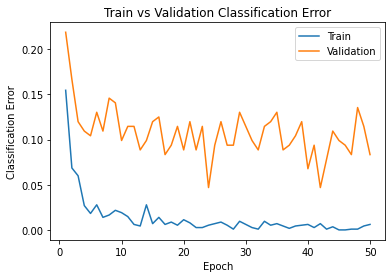

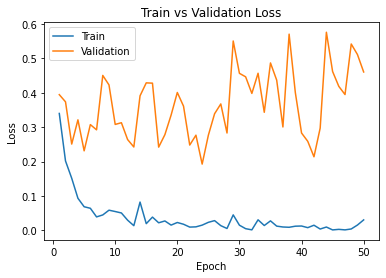

batch size = 64, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'lr': 0.001, 'lrd': 0.6}
Training with CUDA!
Epoch 1: Train err: 0.13494318181818182, Train loss: 0.2832817821340127 | Val err: 0.17578125, Val loss: 0.3596889227628708 | Time: 46.80
Epoch 2: Train err: 0.09161931818181818, Train loss: 0.22906081988052887 | Val err: 0.1015625, Val loss: 0.2817109450697899 | Time: 68.55
Epoch 3: Train err: 0.1015625, Train loss: 0.27408033169128676 | Val err: 0.125, Val loss: 0.36785516142845154 | Time: 89.18
Epoch 4: Train err: 0.03196022727272727, Train loss: 0.125545510514216 | Val err: 0.08203125, Val loss: 0.25743864476680756 | Time: 109.93
Epoch 5: Train err: 0.022727272727272728, Train loss: 0.06361699104309082 | Val err: 0.09765625, Val loss: 0.24731827713549137 | Time: 130.84
Epoch 6: Train err: 0.009943181818181818, Train loss: 0.044157921759919685 | Val err: 0.07421875, Val loss: 0.23579397425055504 | Time: 151.40
Epoch 7: Train err: 0.0234375, Train loss: 0.06684105640107935 | Val err: 0.109375, Val loss: 0.28099657967686653 | Time: 171.95


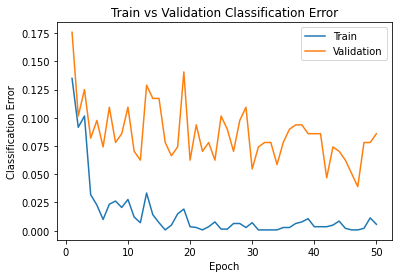

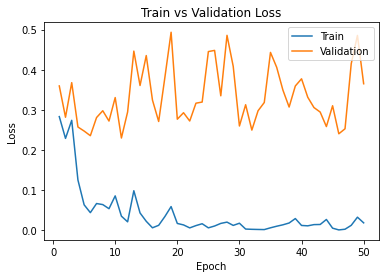

In [36]:
bs_list = [64]
lr_list = [0.001]
lrd_list = [0.5, 0.6]
for bs in bs_list:
  for lr in lr_list:
    for lrd in lrd_list:
      # Train with batch size and learning rate
      print('batch size = {}, learning rate = {}'.format(bs, lr))
      train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
      use_cuda = True
      model = TransferDenseNet121Classifier_AdamLRD()
      _, kwargs = split_optim_dict(optim_dict['adam_lrd'])
      kwargs['lr'], kwargs['lrd'] = lr, lrd
      print(kwargs)
      optimizer = task_to_optimizer('adam_lrd')(params=model.parameters(), **kwargs)
      optimizer = wrap_optimizer('adam_lrd', optimizer)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print("Training with CUDA!")
      else:
        print("CUDA not available...")
      other_param_names = 'lr{}_lrd{}'.format(lr, lrd)
      train(model, train_loader, val_loader, optimizer, other_param_names, batch_size=bs, num_epochs=50)

      # Plotting
      model_path = get_model_name('densenet121Classifier_adamLRD', bs, other_param_names, epoch=50)
      plot_training_curve(model_path, epochs=50)

### False Positive and False Negative

In [24]:
def evaluate_loss_err_fp_fn(net, loader, criterion):
    #predicted 1, actually truth is 0
    total_false_positive = 0.0
    #predicted 0, actually truth is 1
    total_false_negative = 0.0
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)

        #predicted posotive and it is a wrong prediction
        false_pos = (((outputs > 0.0).squeeze().long() != labels) & ((outputs > 0.0).squeeze().long() == 1))
        #predicted posotive and it is a wrong prediction
        false_neg = (((outputs > 0.0).squeeze().long() != labels) & ((outputs > 0.0).squeeze().long() == 0))
        #loss
        loss_val = criterion(outputs+1e-10, labels.float())
        #total_error
        incorrect_pred = (outputs > 0.0).squeeze().long() != labels

        total_false_positive += int(false_pos.sum())
        total_false_negative += int(false_neg.sum())
        total_err += int(incorrect_pred.sum())
        total_loss += loss_val.item()
        total_epoch += len(labels.tolist())

    false_posotive = float(total_false_positive) / total_epoch
    false_negative = float(total_false_negative) / total_epoch
    error = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return false_posotive, false_negative, error, loss

### Best Models

In [44]:
#Settings
bs = 32
lr=0.001
convergence_epoch = 20
print("Best Model's Setting: ")
print('    batch size = {}, learning rate = {}'.format(bs, lr))

#Load Data
train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
print("Finished loading data...")

#Load Model
# use_cuda = True
model = TransferDenseNet121Classifier_Adam()
_, kwargs = split_optim_dict(optim_dict['adam'])
# lr, mu, lrd = lr, mu, lrd
lr, weight_decay = 0.001, 1e-4

kwargs['lr'] = lr
print("Best Model's Optimizer's Setting: ")
print("    ", kwargs)
optimizer = task_to_optimizer('adam')(params=model.parameters(), **kwargs)
optimizer = wrap_optimizer('adam', optimizer)
# if use_cuda and torch.cuda.is_available():
#   model.cuda()
#   print("Training with CUDA!")
# else:
#   print("CUDA not available...")
use_cuda = False
other_param_names = 'lr{}'.format(lr, )
model_path = get_model_name('densenet121Classifier_adam', bs, other_param_names, epoch=convergence_epoch)
# no cuda version: 
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# state = torch.load(model_path)
# model.load_state_dict(state)
print("Finished loading model...")

#get error, false positive, false negative on test set 
print("Starting to evaluate model's performance...")
test_false_posotive, test_false_negative, test_err, test_loss = evaluate_loss_err_fp_fn(model, test_loader, nn.BCEWithLogitsLoss())
print("    Test classification error of the best model is:", test_err)
print("    Test false positive rate of the best model is:", test_false_posotive)
print("    Test false negative rate of the best model is:", test_false_negative)

Best Model's Setting: 
    batch size = 32, learning rate = 0.001
Finished loading data...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Best Model's Optimizer's Setting: 
     {'lr': 0.001}
Finished loading model...
Starting to evaluate model's performance...
    Test classification error of the best model is: 0.10416666666666667
    Test false positive rate of the best model is: 0.0625
    Test false negative rate of the best model is: 0.041666666666666664


In [25]:
#Settings
bs = 64
lr=0.001
lrd=0.3
convergence_epoch = 30
print("Best Model's Setting: ")
print('    batch size = {}, learning rate = {}'.format(bs, lr))

#Load Data
train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
print("Finished loading data...")

#Load Model
# use_cuda = True
model = TransferDenseNet121Classifier_AdamLRD()
_, kwargs = split_optim_dict(optim_dict['adam_lrd'])
# lr, mu, lrd = lr, mu, lrd
lr, lrd = 0.001, 0.3

kwargs['lr'], kwargs['lrd'] = lr, lrd
print("Best Model's Optimizer's Setting: ")
print("    ", kwargs)
optimizer = task_to_optimizer('adam_lrd')(params=model.parameters(), **kwargs)
optimizer = wrap_optimizer('adam_lrd', optimizer)
# if use_cuda and torch.cuda.is_available():
#   model.cuda()
#   print("Training with CUDA!")
# else:
#   print("CUDA not available...")
use_cuda = False
other_param_names = 'lr{}_lrd{}'.format(lr, lrd)
model_path = get_model_name('densenet121Classifier_adamLRD', bs, other_param_names, epoch=convergence_epoch)
# no cuda version: 
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# state = torch.load(model_path)
# model.load_state_dict(state)
print("Finished loading model...")

#get error, false positive, false negative on test set 
print("Starting to evaluate model's performance...")
test_false_posotive, test_false_negative, test_err, test_loss = evaluate_loss_err_fp_fn(model, test_loader, nn.BCEWithLogitsLoss())
print("    Test classification error of the best model is:", test_err)
print("    Test false positive rate of the best model is:", test_false_posotive)
print("    Test false negative rate of the best model is:", test_false_negative)

Best Model's Setting: 
    batch size = 64, learning rate = 0.001
Finished loading data...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Best Model's Optimizer's Setting: 
     {'lr': 0.001, 'lrd': 0.3}
Finished loading model...
Starting to evaluate model's performance...
    Test classification error of the best model is: 0.078125
    Test false positive rate of the best model is: 0.05078125
    Test false negative rate of the best model is: 0.02734375


Useful Links:  
https://www.kaggle.com/code/jaeboklee/pytorch-transfer-learning-with-densenet/notebook
https://www.upgrad.com/blog/basic-cnn-architecture/  
https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8300985/

https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8
https://www.kaggle.com/code/portgasray/covid-19-detection-with-x-ray-covid19-pytorch